# Methods for Portfolio Optimization

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import linprog
from tabulate import tabulate

### Function

In [2]:
# Funzione per calcolare il rendimento di un portafoglio
def portfolio_return(weights, mean_returns):
    return np.dot(weights.T, mean_returns)

# Funzione per calcolare il rischio (varianza) di un portafoglio
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Funzione per minimizzare il rischio dato un livello di rendimento atteso
def minimize_risk(weights, mean_returns, cov_matrix, target_return):
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, mean_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))
    result = minimize(portfolio_risk, len(mean_returns) * [1. / len(mean_returns)], args=(cov_matrix,), 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def generate_random_array(n):
    random_nums = np.random.rand(n)
    total = np.sum(random_nums)
    random_array = random_nums / total
    return random_array

def calculate_annual_return(weekly_mean_return):
    
    # Convert the weekly mean return from percentage to decimal
    weekly_return_decimal = weekly_mean_return / 100
    
    # Calculate the annual return using the compound interest formula
    annual_return_decimal = (1 + weekly_return_decimal) ** 52 - 1
    
    # Convert the annual return back to percentage
    annual_return_percentage = annual_return_decimal * 100
    
    return annual_return_percentage

## Dataset
https://www.francescocesarone.com/data-sets


### Ftse100

FTSE100 FOLDER

The folder contains the weekly linear returns for the Ftse100 from 01-22-2007 to 05-06-2013.
These returns are available into two extensions (.txt & .mat).

The files 'IndRet_Ftse100' contain a column vector which is the weekly linear returns of the market index values.

The files 'RR_Ftse100' contain a matrix where each column is the weekly linear returns of each asset.

NOTE: The returns are calculated from the weekly prices adjusted for dividends downloaded from yahoo.finance.com. 
Stocks with more than two consecutive missing values were disregarded, while the individual missing values were 
interpolated. 

In [94]:
PORTFOLIO = 'Ftse100'

mat_file_1 = 'Ftse100/IndRet_Ftse100.mat'
mat_file_2 = 'Ftse100/RR_Ftse100.mat'

mat_data_1 = scipy.io.loadmat(mat_file_1)
mat_data_2 = scipy.io.loadmat(mat_file_2)

array_ret = mat_data_1['Ret_ftse100'].flatten()
matrix_ret = mat_data_1['Ret_ftse100']
matrix_rr = mat_data_2['RR']

# Calcola i rendimenti medi e la matrice di covarianza
mean_returns = np.mean(matrix_rr, axis=0)
cov_matrix = np.cov(matrix_rr, rowvar=False)

nStocks = len(matrix_rr.T)
print(nStocks)

63


### Stoxx50

EUROSTOXX50 FOLDER

The folder contains the weekly linear returns for the Eurostoxx50 from 01-22-2007 to 05-06-2013.
These returns are available into two extensions (.txt & .mat).

The files 'IndRet_Stoxx50' contain a column vector which is the weekly linear returns of the market index values.

The files 'RR_Stoxx50' contain a matrix where each column is the weekly linear returns of each asset.

NOTE: The returns are calculated from the weekly prices adjusted for dividends downloaded from yahoo.finance.com. 
Stocks with more than two consecutive missing values were disregarded, while the individual missing values were 
interpolated. 

In [124]:
PORTFOLIO = 'EuroStoxx50'

mat_file_1 = 'EuroStoxx50/IndRet_Stoxx50.mat'
mat_file_2 = 'EuroStoxx50/RR_Stoxx50.mat'

mat_data_1 = scipy.io.loadmat(mat_file_1)
mat_data_2 = scipy.io.loadmat(mat_file_2)

array_ret = mat_data_1['Ret_stoxx50'].flatten()
matrix_ret = mat_data_1['Ret_stoxx50']
matrix_rr = mat_data_2['RR']

# Calcola i rendimenti medi e la matrice di covarianza
mean_returns = np.mean(matrix_rr, axis=0)
cov_matrix = np.cov(matrix_rr, rowvar=False)

nStocks = len(matrix_rr.T)
print(nStocks)

32


### FTSE Mib

The folder contains the weekly linear returns for the FtseMib from 01-22-2007 to 05-06-2013.
These returns are available into two extensions (.txt & .mat).

The files 'IndRet_FtseMib' contain a column vector which is the weekly linear returns of the market index values.

The files 'RR_FtseMib' contain a matrix where each column is the weekly linear returns of each asset.

NOTE: The returns are calculated from the weekly prices adjusted for dividends downloaded from yahoo.finance.com. 
Stocks with more than two consecutive missing values were disregarded, while the individual missing values were 
interpolated. 

In [5]:
PORTFOLIO = 'FSTE Mib'

mat_file_1 = 'FtseMib/IndRet_FtseMib.mat'
mat_file_2 = 'FtseMib/RR_FtseMib.mat'

mat_data_1 = scipy.io.loadmat(mat_file_1)
mat_data_2 = scipy.io.loadmat(mat_file_2)

array_ret = mat_data_1['Ret_ftsemib'].flatten()
matrix_ret = mat_data_1['Ret_ftsemib']
matrix_rr = mat_data_2['RR']

# Calcola i rendimenti medi e la matrice di covarianza
mean_returns = np.mean(matrix_rr, axis=0)
cov_matrix = np.cov(matrix_rr, rowvar=False)

nStocks = len(matrix_rr.T)
print(nStocks)

34


## Analytics

Index Name: EuroStoxx50
N. Stock: 32


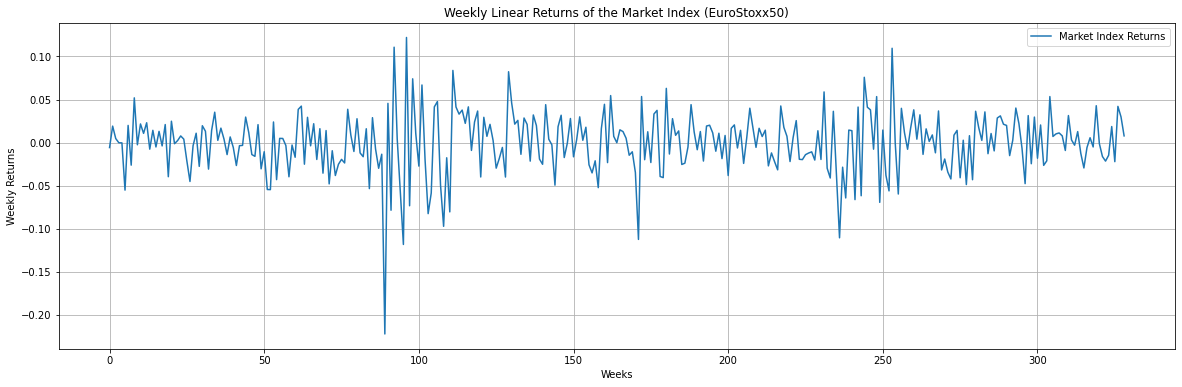

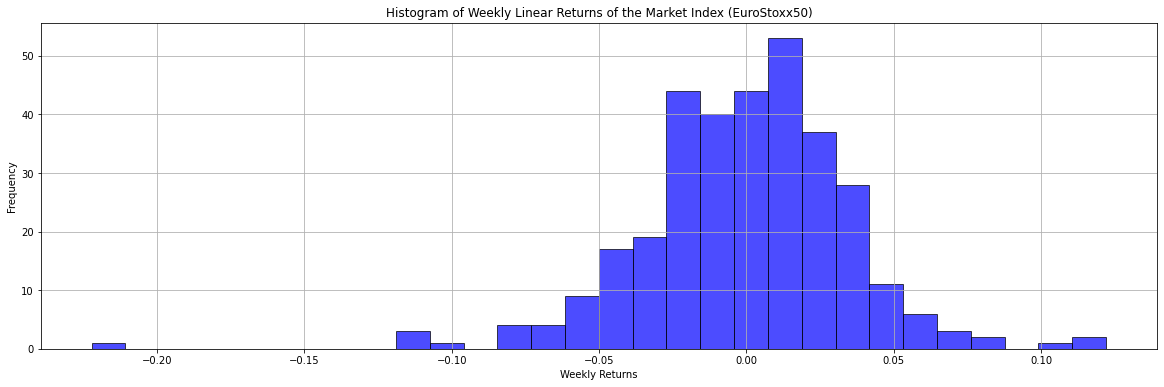

In [125]:
print(f"Index Name: {PORTFOLIO}")
print(f"N. Stock: {nStocks}")

# Grafico del rendimento settimanale dell'indice di mercato
plt.figure(figsize=(20, 6))
plt.plot(array_ret, label='Market Index Returns')
plt.xlabel('Weeks')
plt.ylabel('Weekly Returns')
plt.title('Weekly Linear Returns of the Market Index (EuroStoxx50)')
plt.legend()
plt.grid(True)
plt.show()

# Istogramma dei rendimenti settimanali del mercato
plt.figure(figsize=(20, 6))
plt.hist(array_ret, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Weekly Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Weekly Linear Returns of the Market Index (EuroStoxx50)')
plt.grid(True)
plt.show()

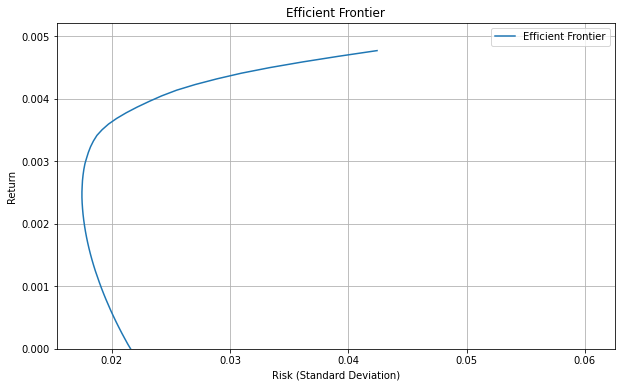

In [126]:
# Calcola la frontiera efficiente
target_returns = np.linspace(min(mean_returns), max(mean_returns), 100)
efficient_portfolios = []

for target_return in target_returns:
    efficient_portfolios.append(minimize_risk(len(mean_returns) * [1. / len(mean_returns)], mean_returns, cov_matrix, target_return))

# Estrai i rischi e i rendimenti dei portafogli efficienti
risks = [portfolio_risk(x['x'], cov_matrix) for x in efficient_portfolios]
returns = [portfolio_return(x['x'], mean_returns) for x in efficient_portfolios]

# Visualizza la frontiera efficiente
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, label='Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.ylim(0) 
plt.legend()
plt.grid(True)
plt.show()

In [127]:
# Plotting Function
def plot_results(loss_values, grad_values, returns_iteration, optimal_weights, label):
    # Plotting the metrics
    plt.figure(figsize=(20, 5))

    # Loss Function Values
    plt.subplot(1, 3, 1)
    plt.plot(loss_values)
    plt.title('Objective Function Value')
    plt.xlabel('Iteration')
    plt.ylabel('Value')

    # Norm Gradient Values
    plt.subplot(1, 3, 2)
    plt.plot(grad_values)
    plt.title('Norm Gradient Value')
    plt.xlabel('Iteration')
    plt.ylabel('Value')

    plt.subplot(1, 3, 3)
    plt.plot(returns_iteration, label=label)
    plt.title('Return over Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Return Mean')
    plt.legend()

    ret_mean_aw = checkMeanRet(optimal_weights, mean_returns) * 100
    risk_aw = portfolio_risk(optimal_weights, cov_matrix)

    print('\n' + PORTFOLIO)
    print(f"Max Weights: {np.max(optimal_weights)}")
    print("Sum of weights:", np.sum(optimal_weights))
    print('Weekly Return Portfolio: ', np.round(ret_mean_aw, 5), "%")
    print('Yearly Return Portfolio: ', calculate_annual_return(ret_mean_aw), "%")
    print("Risk: ", np.round(risk_aw,3), "%")

    # Plotting the histogram
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(optimal_weights)), optimal_weights, color='skyblue')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Histogram of weights')
    plt.xticks(range(len(optimal_weights)), labels=[f'Element {i+1}' for i in range(len(optimal_weights))])
    plt.grid(axis='y')

    # Display the plot
    plt.tight_layout()
    plt.show()

## Portfolio Optimizations

We have $n$ avaiable assets. We call $w_i$ the quantity of money invested on the
$i$-th asset during the considered period and with $r_i$ the returns on the $i$-th
asset. We have two different constraints. The first one is non-negativity for the
variables (i.e., $w_i$ ≥ 0). It basically means that short selling (selling asset that
we still don’t own) is not allowed. We then have the budget constraint:

$
\begin{equation}
\sum_{i=1}^{n} w_i = B
\end{equation}
$

the total amount of money invested needs to be equal to the budget $B$ ($B$ can be simply set to 1).
Consider a stochastic model for the returns: $r ∈ R^n$ is a randomly generated vector with mean $\overline{r}$ and covariance $\Sigma$. Thus expected return will be:
$
\begin{equation}
\overline{r}^\intercal \, w
\end{equation}
$
and variance (risk)
$
\begin{equation}
w^\intercal \, \Sigma \, w
\end{equation}
$
Classic portfolio problem, described by Markowitz (1952), is a convex quadratic programming problem:
$
\begin{equation}
\begin{split}
\underset{w∈R^n}{min} \quad \gamma \, w^\intercal \, \Sigma \, w - \overline{r}^\intercal \, w \\
s.t. \quad e^\intercal w = 1 \\
w > 0
\end{split}
\end{equation} 
$
with $\gamma$ > 0 risk-aversion parameter. Goal is thus finding the set of assets that
minimizes the variance (risk connected to the given portfolio) while maximizing
the expected return (we obviously need to satisfy budget and non-negativity
constraints).

In [128]:
def checkMeanRet(weights, ret_mean):
    return np.dot(ret_mean.T, weights)

def loss(weights, ret_mean, cov, RISK_AVERSION):
    return  np.dot(RISK_AVERSION, np.dot(weights.T, np.dot(cov, weights))) -  np.dot(ret_mean.T, weights)

### Gradient

$
\begin{equation}
\nabla f(w_k) = 2 \, \gamma \, \Sigma \, w - \overline{r}^\intercal\\
\end{equation} 
$

In [129]:
def gradient(weights, ret_mean, cov, RISK_AVERSION):
    return  RISK_AVERSION * 2 * np.dot(weights, cov) -  ret_mean.T

## Frank-Wolfe and Pairwise Frank-Wolfe over the Markowitz portfolio problems

In [151]:
RISK_AVERSION = 1

In [152]:
def linearMinimizationOracle2(grad):
    c = grad # Use the positive gradient for minimization
    A_eq = np.ones((1, nStocks))
    b_eq = np.array([1])
    bounds = [(0, 1) for _ in range(nStocks)]
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    return res.x

def linearMinimizationOracle(grad):
    """
    Linear Minimization Oracle (LMO) without using linprog.
    """
    s = np.zeros_like(grad)
    s[np.argmin(grad)] = 1  # Set the position with the smallest gradient to 1
    return s

def line_search(weights, direction, ret_mean, cov_matrix, RISK_AVERSION):
    gamma_range = np.linspace(0, 1, 100)
    losses = [loss((1 - gamma) * weights + gamma * direction, ret_mean, cov_matrix, RISK_AVERSION) for gamma in gamma_range]
    optimal_gamma = gamma_range[np.argmin(losses)]
    return optimal_gamma

def duality_gap(weights, grad):
    """
    Compute the duality gap for the given weights and gradient.
    """
    s = linearMinimizationOracle(grad)
    return np.dot(grad, weights - s)

### Frank-Wolfe

05% - ret 00.08% - loss -0.002307
10% - ret 00.35% - loss -0.003004
15% - ret 00.37% - loss -0.003145
20% - ret 00.41% - loss -0.003297
25% - ret 00.40% - loss -0.003308
30% - ret 00.39% - loss -0.003355
35% - ret 00.41% - loss -0.003411
40% - ret 00.41% - loss -0.003415
45% - ret 00.42% - loss -0.003445
50% - ret 00.42% - loss -0.003440
55% - ret 00.43% - loss -0.003460
60% - ret 00.42% - loss -0.003451
65% - ret 00.41% - loss -0.003453
70% - ret 00.42% - loss -0.003469
75% - ret 00.42% - loss -0.003471
80% - ret 00.41% - loss -0.003477
85% - ret 00.42% - loss -0.003479
90% - ret 00.42% - loss -0.003481
95% - ret 00.42% - loss -0.003483

EuroStoxx50
Max Weights: 0.5096464894839503
Sum of weights: 1.0
Weekly Return Portfolio:  0.4199 %
Yearly Return Portfolio:  24.34490934559843 %
Risk:  0.027 %


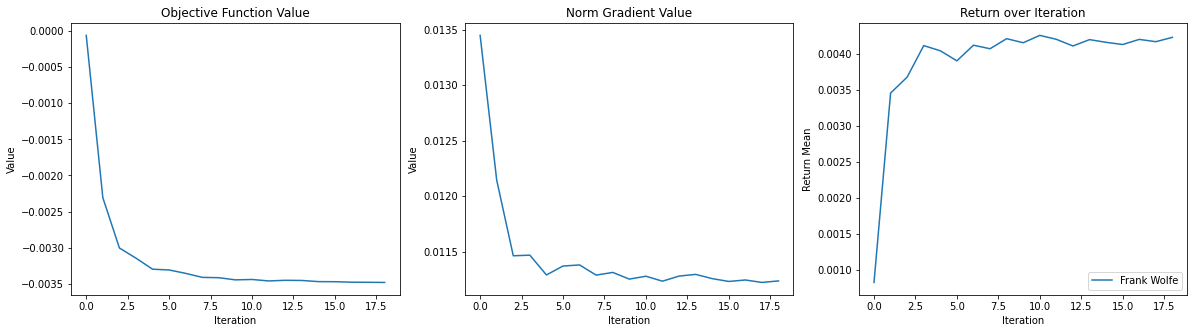

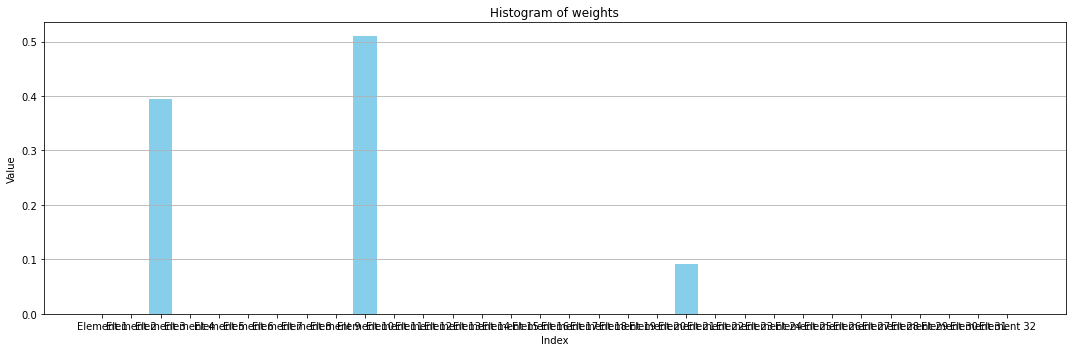

CPU times: user 1.32 s, sys: 106 ms, total: 1.43 s
Wall time: 917 ms


In [153]:
%%time

ITERATIONS = 20

weights = generate_random_array(nStocks)

loss_values_fw = []
grad_values_fw = []
returns_iteration_fw = []

for itr in range(1, ITERATIONS):
    if itr % (ITERATIONS * 0.05) == 0:
        print(f"{int(itr/ITERATIONS*100):02}%", end="")

    grad = gradient(weights, mean_returns, cov_matrix, RISK_AVERSION)
    s = linearMinimizationOracle(grad)

    # Store values for plotting
    loss_values_fw.append(loss(weights, mean_returns, cov_matrix, RISK_AVERSION))
    grad_values_fw.append(np.linalg.norm(grad))
    returns_iteration_fw.append(checkMeanRet(weights, mean_returns))

    gamma = 2 / (itr + 2) 
    weights = (1 - gamma) * weights + gamma * s
    
    current_loss = loss(weights, mean_returns, cov_matrix, RISK_AVERSION)

    if abs(duality_gap(weights, grad)) < 1e-6: 
        print('Duality Gap Convergence itr: ', itr)
        break 

    if itr % (ITERATIONS * 0.05) == 0:
        print(f" - ret {(returns_iteration_fw[-1])*100:05.2f}% - loss {loss(weights, mean_returns, cov_matrix, RISK_AVERSION):05.6f}")

optimal_weights_fw = weights

plot_results(loss_values_fw, grad_values_fw, returns_iteration_fw, optimal_weights_fw, 'Frank Wolfe')

### Frank Wolfe Line Search

00% - ret 00.10% - loss -0.002972
05% - ret 00.48% - loss -0.003484
10% - ret 00.43% - loss -0.003497
15% - ret 00.42% - loss -0.003497
20% - ret 00.42% - loss -0.003497
25% - ret 00.42% - loss -0.003497
30% - ret 00.42% - loss -0.003497
35% - ret 00.42% - loss -0.003497
40% - ret 00.42% - loss -0.003497
45% - ret 00.42% - loss -0.003497
50% - ret 00.42% - loss -0.003497
55% - ret 00.42% - loss -0.003497
60% - ret 00.42% - loss -0.003497
65% - ret 00.42% - loss -0.003497
70% - ret 00.42% - loss -0.003497
75% - ret 00.42% - loss -0.003497
80% - ret 00.42% - loss -0.003497
85% - ret 00.42% - loss -0.003497
90% - ret 00.42% - loss -0.003497
95% - ret 00.42% - loss -0.003497

EuroStoxx50
Max Weights: 0.48440623858098264
Sum of weights: 0.9999999999999999
Weekly Return Portfolio:  0.42183 %
Yearly Return Portfolio:  24.469217546363463 %
Risk:  0.027 %


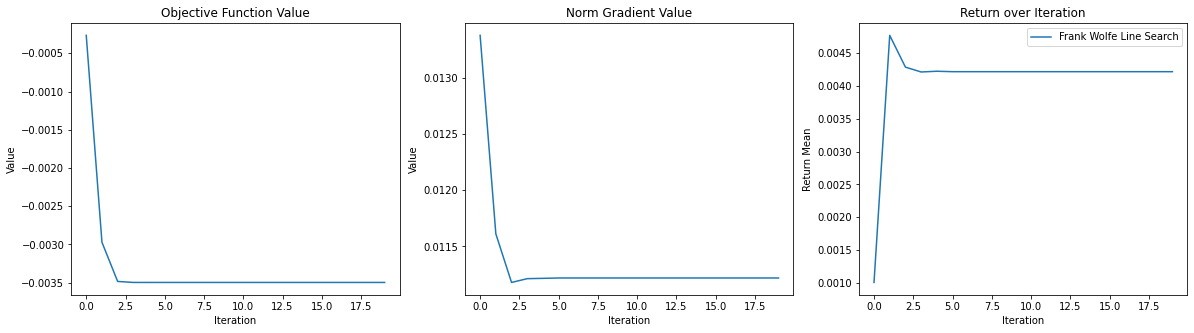

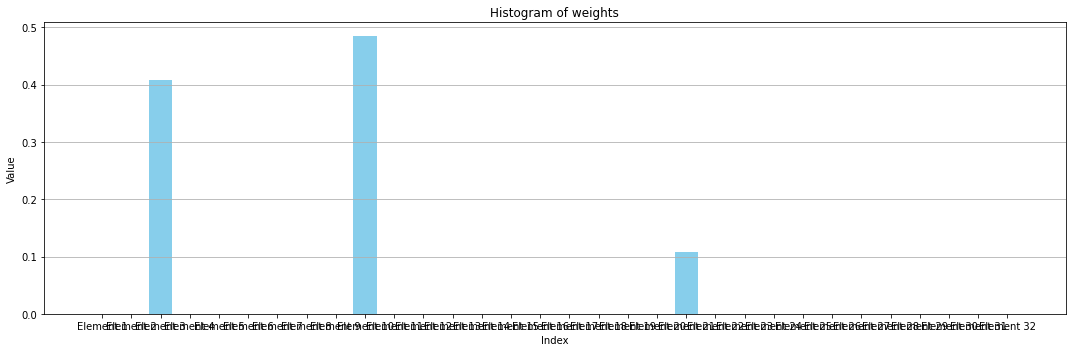

In [154]:
ITERATIONS = 20

loss_values_ls = []
grad_values_ls = []
returns_iteration_ls = []

weights = np.ones(nStocks) / nStocks

for itr in range(ITERATIONS):
    if itr % (ITERATIONS * 0.05) == 0:
        print(f"{int(itr/ITERATIONS*100):02}%", end="")

    grad = gradient(weights, mean_returns, cov_matrix, RISK_AVERSION)
    s = linearMinimizationOracle(grad)

    # Store values for plotting
    loss_values_ls.append(loss(weights, mean_returns, cov_matrix, RISK_AVERSION))
    grad_values_ls.append(np.linalg.norm(grad))
    returns_iteration_ls.append(checkMeanRet(weights, mean_returns))
    
    # Calcola il passo ottimale con la line search
    gamma = line_search(weights, s, mean_returns, cov_matrix, RISK_AVERSION)
    weights = (1 - gamma) * weights + gamma * s
    
    # Proiezione per assicurare che i pesi siano validi
    weights = np.clip(weights, 0, 1)
    weights /= np.sum(weights)
    
    # Verifica la convergenza
    if np.linalg.norm(grad) < 1e-6:
        break

    if itr % (ITERATIONS * 0.05) == 0:
        print(f" - ret {(returns_iteration_ls[-1])*100:05.2f}% - loss {loss(weights, mean_returns, cov_matrix, RISK_AVERSION):05.6f}")

# Esegui l'ottimizzazione
optimal_weights_ls = weights

plot_results(loss_values_ls, grad_values_ls, returns_iteration_ls, optimal_weights_ls, 'Frank Wolfe Line Search')

### PairWise Frank Wolfe

00% - ret 00.10% - loss -0.002010
05% - ret 00.29% - loss -0.002701
10% - ret 00.33% - loss -0.002973
15% - ret 00.39% - loss -0.003211
20% - ret 00.39% - loss -0.003203
25% - ret 00.38% - loss -0.003311
30% - ret 00.42% - loss -0.003431
35% - ret 00.41% - loss -0.003398
40% - ret 00.44% - loss -0.003468
45% - ret 00.42% - loss -0.003361
50% - ret 00.39% - loss -0.003399
55% - ret 00.43% - loss -0.003486
60% - ret 00.41% - loss -0.003431
65% - ret 00.44% - loss -0.003489
70% - ret 00.42% - loss -0.003374
75% - ret 00.40% - loss -0.003407
80% - ret 00.43% - loss -0.003491
85% - ret 00.42% - loss -0.003434
90% - ret 00.44% - loss -0.003491
95% - ret 00.42% - loss -0.003375

EuroStoxx50
Max Weights: 0.4134874402307194
Sum of weights: 1.0000000000000002
Weekly Return Portfolio:  0.39648 %
Yearly Return Portfolio:  22.84635864855462 %
Risk:  0.024 %


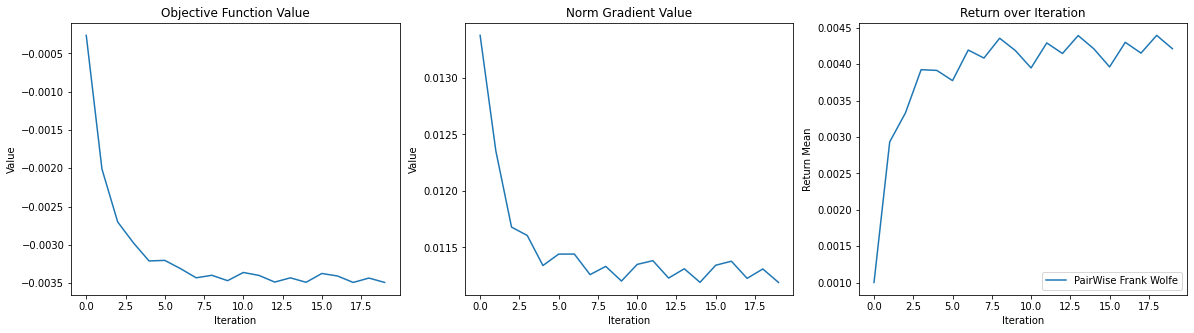

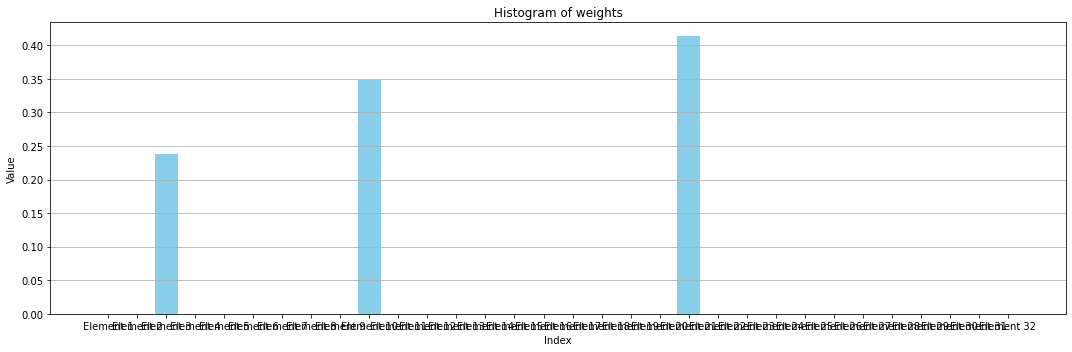

In [155]:
ITERATIONS = 20

loss_values_pw = []
grad_values_pw = []
returns_iteration_pw = []

weights = np.ones(nStocks) / nStocks

for itr in range(ITERATIONS):
    if itr % (ITERATIONS * 0.05) == 0:
        print(f"{int(itr/ITERATIONS*100):02}%", end="")

    grad = gradient(weights, mean_returns, cov_matrix, RISK_AVERSION)
    
    # Trova gli indici con il gradiente minimo e massimo
    i = np.argmin(grad)
    j = np.argmax(grad)

    # Store values for plotting
    loss_values_pw.append(loss(weights, mean_returns, cov_matrix, RISK_AVERSION))
    grad_values_pw.append(np.linalg.norm(grad))
    returns_iteration_pw.append(checkMeanRet(weights, mean_returns))
    
    direction = np.zeros_like(weights)
    direction[i] = 1
    direction[j] = -1

    gamma = line_search(weights, direction, mean_returns, cov_matrix, RISK_AVERSION)

    weights += gamma * direction

    weights = np.clip(weights, 0, 1)
    weights /= np.sum(weights)
    
    if np.linalg.norm(grad) < 1e-6:
        break

    if itr % (ITERATIONS * 0.05) == 0:
        print(f" - ret {(returns_iteration_pw[-1])*100:05.2f}% - loss {loss(weights, mean_returns, cov_matrix, RISK_AVERSION):05.6f}")


optimal_weights_pw = weights

plot_results(loss_values_pw, grad_values_pw, returns_iteration_pw, optimal_weights_pw, 'PairWise Frank Wolfe')

### Away Step Frank Wolfe

00% - ret 00.10% - loss -0.002943
05% - ret 00.47% - loss -0.003032
10% - ret 00.47% - loss -0.003063
15% - ret 00.47% - loss -0.003094
20% - ret 00.47% - loss -0.003094
25% - ret 00.47% - loss -0.003094
30% - ret 00.47% - loss -0.003094
35% - ret 00.47% - loss -0.003094
40% - ret 00.47% - loss -0.003094
45% - ret 00.47% - loss -0.003094
50% - ret 00.47% - loss -0.003094
55% - ret 00.47% - loss -0.003094
60% - ret 00.47% - loss -0.003094
65% - ret 00.47% - loss -0.003094
70% - ret 00.47% - loss -0.003094
75% - ret 00.47% - loss -0.003094
80% - ret 00.47% - loss -0.003094
85% - ret 00.47% - loss -0.003094
90% - ret 00.47% - loss -0.003094
95% - ret 00.47% - loss -0.003094

EuroStoxx50
Max Weights: 0.9293454675749485
Sum of weights: 1.0
Weekly Return Portfolio:  0.47108 %
Yearly Return Portfolio:  27.683738048011342 %
Risk:  0.04 %


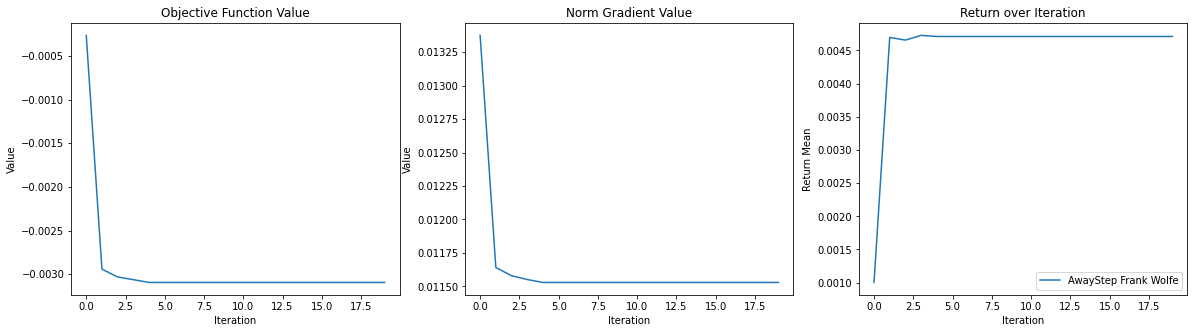

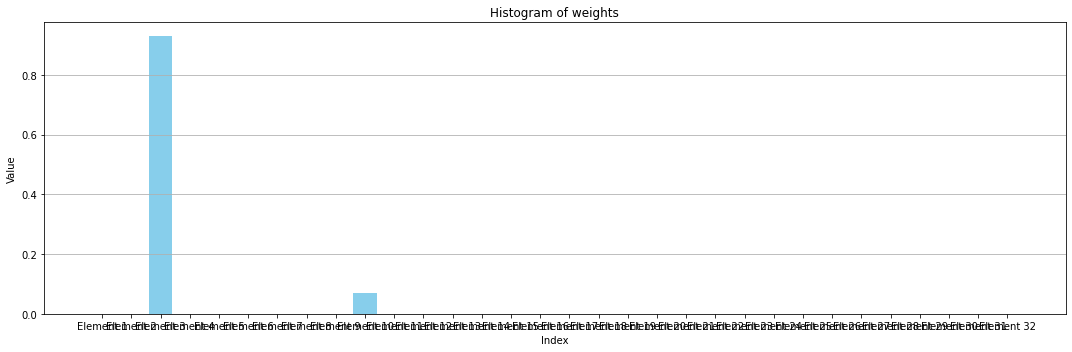

CPU times: user 1.11 s, sys: 43.1 ms, total: 1.15 s
Wall time: 601 ms


In [156]:
%%time

ITERATIONS = 20

loss_values_aw = []
grad_values_aw = []
returns_iteration_aw = []

weights = np.ones(nStocks) / nStocks
V = [weights.copy()]  # Memorizza i vertici visitati

for itr in range(ITERATIONS):
    if itr % (ITERATIONS * 0.05) == 0:
        print(f"{int(itr/ITERATIONS*100):02}%", end="")

    grad = gradient(weights, mean_returns, cov_matrix, RISK_AVERSION)
    
    # Direzione Frank-Wolfe
    s = linearMinimizationOracle(grad)
    d_fw = s - weights
    
    # Direzione di allontanamento
    j = np.argmax(np.dot(V, grad))
    v_j = V[j]
    d_away = weights - v_j
    
    # Determina la direzione e il passo ottimali
    if np.dot(grad, d_fw) < np.dot(grad, d_away):
        direction = d_fw
        step_size = 1.0  # Frank-Wolfe step
    else:
        direction = -d_away
        max_step_size = np.min(weights[weights > 0] / (weights[weights > 0] - v_j[weights > 0]))
        step_size = min(1.0, max_step_size)  # Away step

    # Store values for plotting
    loss_values_aw.append(loss(weights, mean_returns, cov_matrix, RISK_AVERSION))
    grad_values_aw.append(np.linalg.norm(grad))
    returns_iteration_aw.append(checkMeanRet(weights, mean_returns))

    gamma = line_search(weights, direction, mean_returns, cov_matrix, RISK_AVERSION)
    gamma = min(gamma, step_size)

    weights += gamma * direction
    weights = np.clip(weights, 0, 1)
    weights /= np.sum(weights)
    
    # Aggiungi nuovo vertice
    if np.array_equal(direction, d_fw):
        V.append(s.copy())
    else:
        if step_size == max_step_size and len(V) > 1:
            V.pop(j)  # Rimuovi vertice

    if np.linalg.norm(grad) < 1e-6:
        break

    if itr % (ITERATIONS * 0.05) == 0:
        print(f" - ret {(returns_iteration_aw[-1])*100:05.2f}% - loss {loss(weights, mean_returns, cov_matrix, RISK_AVERSION):05.6f}")
            

# Esegui l'ottimizzazione con Away-step Frank-Wolfe
optimal_weights_aw = weights

plot_results(loss_values_aw, grad_values_aw, returns_iteration_aw, optimal_weights_aw, 'AwayStep Frank Wolfe')

### Scipy Minimize Function


Ottimizzazione con scipy.optimize.minimize
Rendimento Atteso: 0.42146662721194267%
Perdita Ottimale: -0.003485207568210346
Somma dei Pesi: 1.0000000000000002
Risk:  0.027 %
32


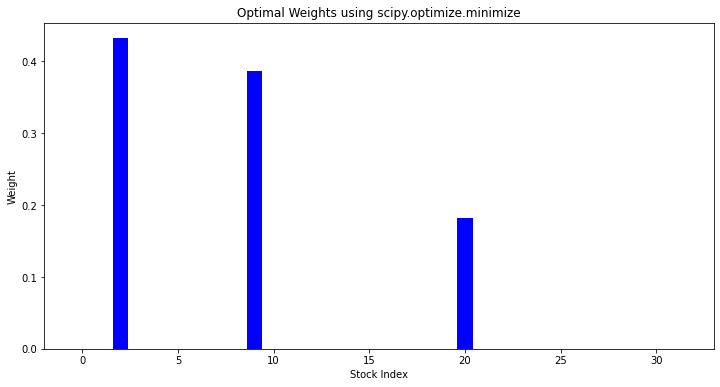

In [157]:
# Vincolo: la somma dei pesi deve essere 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Vincoli: i pesi devono essere tra 0 e 1
bounds = [(0, 1) for _ in range(nStocks)]

# Pesi iniziali
initial_weights = np.ones(nStocks) / nStocks

# Ottimizzazione con scipy.optimize.minimize
result = minimize(loss, initial_weights, args=(mean_returns, cov_matrix, RISK_AVERSION), method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights_scipy = result.x

# Stampa dei risultati
print('\nOttimizzazione con scipy.optimize.minimize')
print(f"Rendimento Atteso: {checkMeanRet(optimal_weights_scipy, mean_returns)*100}%")
print(f"Perdita Ottimale: {loss(optimal_weights_scipy, mean_returns, cov_matrix, RISK_AVERSION)}")
print(f"Somma dei Pesi: {np.sum(optimal_weights_scipy)}")

risk = portfolio_risk(optimal_weights_scipy, cov_matrix)
print("Risk: ", np.round(risk,3), "%")

print(nStocks)
# Plot dell'istogramma dei pesi ottimali
plt.figure(figsize=(12, 6))
plt.bar(range(nStocks), optimal_weights_scipy, color='blue')
plt.xlabel('Stock Index')
plt.ylabel('Weight')
plt.title('Optimal Weights using scipy.optimize.minimize')
plt.show()

## Results Comparison

### Loss Comparison

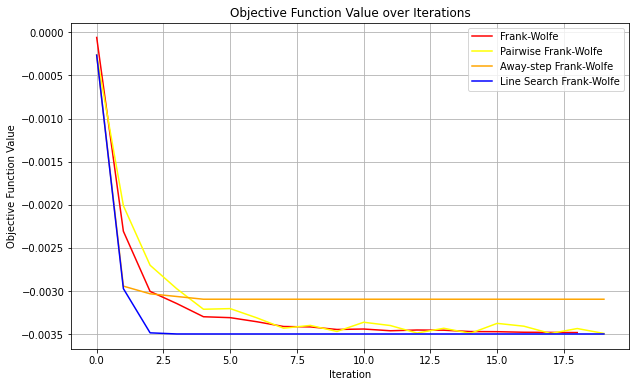

In [158]:
# Plot dei valori della funzione obiettivo
plt.figure(figsize=(10, 6))
plt.plot(loss_values_fw, label='Frank-Wolfe', color='red')
plt.plot(loss_values_pw, label='Pairwise Frank-Wolfe', color='yellow')
plt.plot(loss_values_aw, label='Away-step Frank-Wolfe', color='orange')
plt.plot(loss_values_ls, label='Line Search Frank-Wolfe', color='blue')

# Impostazioni del grafico
plt.title('Objective Function Value over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()

### Efficent Frontier Comparison

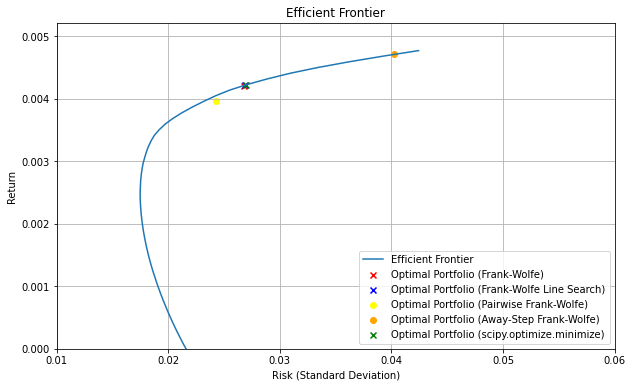

In [159]:
optimal_risk_fw = portfolio_risk(optimal_weights_fw, cov_matrix)
optimal_return_fw = portfolio_return(optimal_weights_fw, mean_returns)

optimal_risk_scipy = portfolio_risk(optimal_weights_scipy, cov_matrix)
optimal_return_scipy = portfolio_return(optimal_weights_scipy, mean_returns)

optimal_risk_linesearch = portfolio_risk(optimal_weights_ls, cov_matrix)
optimal_return_linesearch = portfolio_return(optimal_weights_ls, mean_returns)

optimal_risk_pw = portfolio_risk(optimal_weights_pw, cov_matrix)
optimal_return_pw = portfolio_return(optimal_weights_pw, mean_returns)

optimal_risk_aw = portfolio_risk(optimal_weights_aw, cov_matrix)
optimal_return_aw = portfolio_return(optimal_weights_aw, mean_returns)

# Genera la frontiera efficiente
target_returns = np.linspace(min(mean_returns), max(mean_returns), 100)
efficient_portfolios = []

for target_return in target_returns:
    efficient_portfolios.append(minimize_risk(len(mean_returns) * [1. / len(mean_returns)], mean_returns, cov_matrix, target_return))

# Estrai i rischi e i rendimenti dei portafogli efficienti
risks = [portfolio_risk(x['x'], cov_matrix) for x in efficient_portfolios]
returns = [portfolio_return(x['x'], mean_returns) for x in efficient_portfolios]

# Visualizza la frontiera efficiente
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, label='Efficient Frontier')
plt.scatter(optimal_risk_fw, optimal_return_fw, color='red', label='Optimal Portfolio (Frank-Wolfe)', marker='x')
plt.scatter(optimal_risk_linesearch, optimal_return_linesearch, color='blue', label='Optimal Portfolio (Frank-Wolfe Line Search)', marker='x')
plt.scatter(optimal_risk_pw, optimal_return_pw, color='yellow', label='Optimal Portfolio (Pairwise Frank-Wolfe)', marker='o')
plt.scatter(optimal_risk_aw, optimal_return_aw, color='orange', label='Optimal Portfolio (Away-Step Frank-Wolfe)', marker='o')
plt.scatter(optimal_risk_scipy, optimal_return_scipy, color='green', label='Optimal Portfolio (scipy.optimize.minimize)', marker='x')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.ylim(0) 
plt.xlim(0.01,0.06) 
plt.legend()
plt.grid(True)
plt.show()

### Risk and Return Comparison

In [160]:
# Converti i rendimenti settimanali in rendimenti annuali (approssimando 52 settimane in un anno)
def annualize_return(weekly_return):
    return (1 + weekly_return) ** 52 - 1

# Calcola i rendimenti annuali
annual_return_fw = annualize_return(optimal_return_fw)
annual_return_scipy = annualize_return(optimal_return_scipy)
annual_return_linesearch = annualize_return(optimal_return_linesearch)
annual_return_pw = annualize_return(optimal_return_pw)
annual_return_aw = annualize_return(optimal_return_aw)

# Arrotonda i dati e convertili in percentuale
data = {
    'Method': ['Frank-Wolfe', 'SciPy Optimization', 'Line Search Frank-Wolfe', 'Pairwise Frank-Wolfe', 'Away-step Frank-Wolfe'],
    'Optimal Risk (%)': [round(optimal_risk_fw * 100, 2), round(optimal_risk_scipy * 100, 2), round(optimal_risk_linesearch * 100, 2), round(optimal_risk_pw * 100, 2), round(optimal_risk_aw * 100, 2)],
    'Weekly Return (%)': [round(optimal_return_fw * 100, 2), round(optimal_return_scipy * 100, 2), round(optimal_return_linesearch * 100, 2), round(optimal_return_pw * 100, 2), round(optimal_return_aw * 100, 2)],
    'Annual Return (%)': [round(annual_return_fw * 100, 2), round(annual_return_scipy * 100, 2), round(annual_return_linesearch * 100, 2), round(annual_return_pw * 100, 2), round(annual_return_aw * 100, 2)]
}

results_df = pd.DataFrame(data)
print(tabulate(results_df, headers='keys', tablefmt='pretty'))

+---+-------------------------+------------------+-------------------+-------------------+
|   |         Method          | Optimal Risk (%) | Weekly Return (%) | Annual Return (%) |
+---+-------------------------+------------------+-------------------+-------------------+
| 0 |       Frank-Wolfe       |       2.68       |       0.42        |       24.34       |
| 1 |   SciPy Optimization    |       2.7        |       0.42        |       24.45       |
| 2 | Line Search Frank-Wolfe |       2.69       |       0.42        |       24.47       |
| 3 |  Pairwise Frank-Wolfe   |       2.43       |        0.4        |       22.85       |
| 4 |  Away-step Frank-Wolfe  |       4.02       |       0.47        |       27.68       |
+---+-------------------------+------------------+-------------------+-------------------+


### Investment Simulation

Index: EuroStoxx50
Risk Aversion: 1


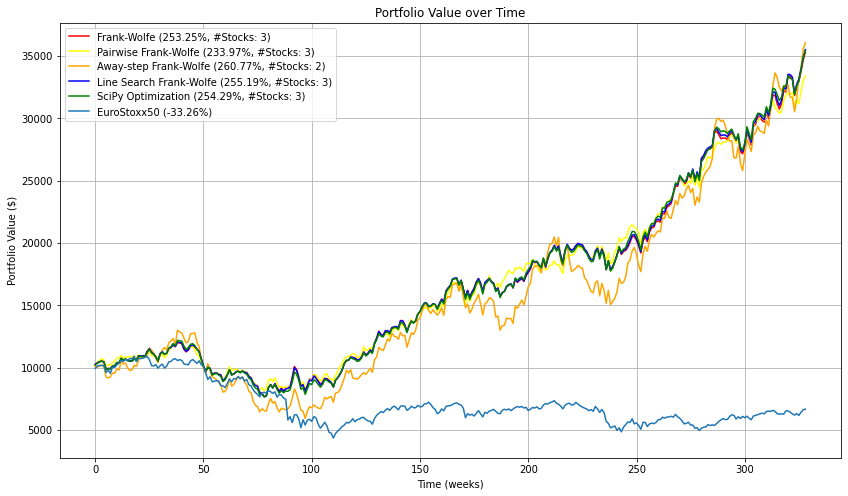

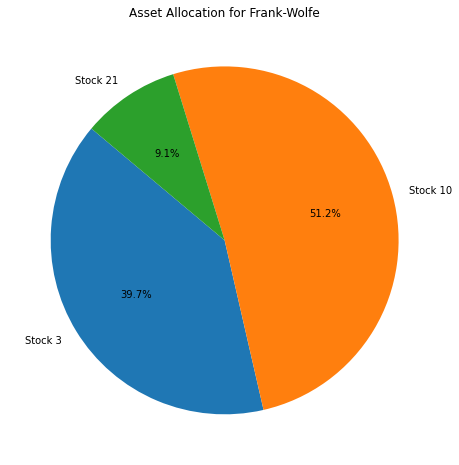

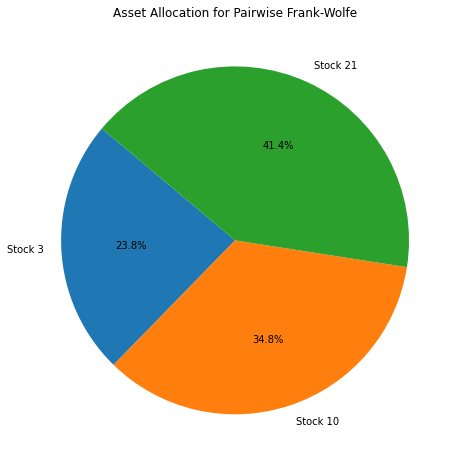

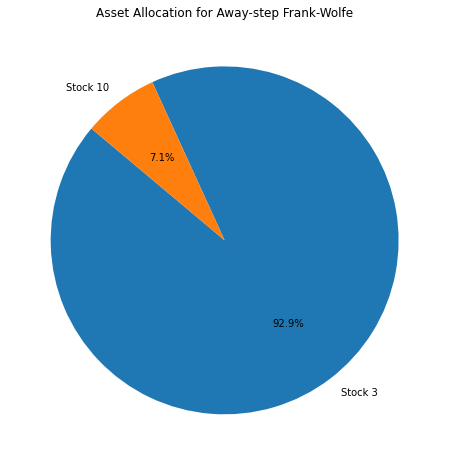

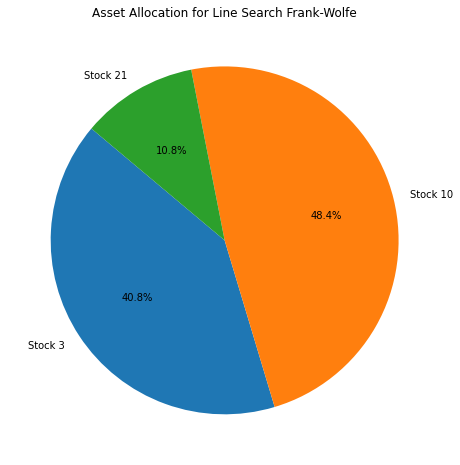

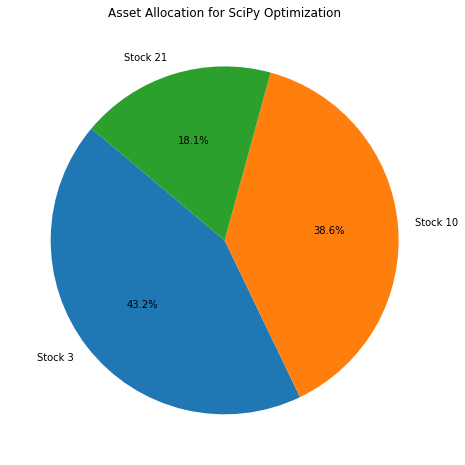

In [161]:
print(f"Index: {PORTFOLIO}")
print(f"Risk Aversion: {RISK_AVERSION}")

initial_investment = 10000

# Funzione per creare un grafico a torta
def plot_pie_chart(weights, method_name):
    positive_weights = weights[weights > 0.0009]
    labels = [f'Stock {i+1}' for i in range(len(weights)) if weights[i] > 0.0009]
    plt.figure(figsize=(8, 8))
    plt.pie(positive_weights, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Asset Allocation for {method_name}')
    plt.show()

# Calcola il valore del portafoglio nel tempo
def portfolio_value(weights, matrix_ret, initial_investment):
    cumulative_returns = np.cumprod(1 + np.dot(matrix_ret, weights))
    return initial_investment * cumulative_returns

def calculate_investment_value(array_ret, initial_investment):
    # Convertiamo i ritorni percentuali in fattori moltiplicativi
    factors = 1 + np.array(array_ret)
    
    # Calcoliamo il valore cumulativo dell'investimento
    cumulative_returns = np.cumprod(factors)
    
    # Moltiplichiamo per l'investimento iniziale
    investment_value = initial_investment * cumulative_returns
    
    return investment_value

# Calcolo del numero di pesi maggiori di zero
def num_positive_weights(weights):
    return np.sum(weights > 0.0009)

# Calcola i valori del portafoglio per ciascun metodo
portfolio_values_fw = portfolio_value(optimal_weights_fw, matrix_rr, initial_investment)
portfolio_values_pw = portfolio_value(optimal_weights_pw, matrix_rr, initial_investment)
portfolio_values_aw = portfolio_value(optimal_weights_aw, matrix_rr, initial_investment)
portfolio_values_ls = portfolio_value(optimal_weights_ls, matrix_rr, initial_investment)
portfolio_values_scipy = portfolio_value(optimal_weights_scipy, matrix_rr, initial_investment)
portfolio_values_index = calculate_investment_value(array_ret, initial_investment)

# Calcola i ritorni percentuali finali
final_return_fw = (portfolio_values_fw[-1] / initial_investment - 1) * 100
final_return_pw = (portfolio_values_pw[-1] / initial_investment - 1) * 100
final_return_aw = (portfolio_values_aw[-1] / initial_investment - 1) * 100
final_return_ls = (portfolio_values_ls[-1] / initial_investment - 1) * 100
final_return_scipy = (portfolio_values_scipy[-1] / initial_investment - 1) * 100
final_return_index = (portfolio_values_index[-1] / initial_investment - 1) * 100

# Calcola il numero di pesi maggiori di zero per ciascun metodo
num_positive_fw = num_positive_weights(optimal_weights_fw)
num_positive_pw = num_positive_weights(optimal_weights_pw)
num_positive_aw = num_positive_weights(optimal_weights_aw)
num_positive_ls = num_positive_weights(optimal_weights_ls)
num_positive_scipy = num_positive_weights(optimal_weights_scipy)

# Plot dei valori del portafoglio nel tempo
plt.figure(figsize=(14, 8))
plt.plot(portfolio_values_fw, label=f'Frank-Wolfe ({final_return_fw:.2f}%, #Stocks: {num_positive_fw})', color='red')
plt.plot(portfolio_values_pw, label=f'Pairwise Frank-Wolfe ({final_return_pw:.2f}%, #Stocks: {num_positive_pw})', color='yellow')
plt.plot(portfolio_values_aw, label=f'Away-step Frank-Wolfe ({final_return_aw:.2f}%, #Stocks: {num_positive_aw})', color='orange')
plt.plot(portfolio_values_ls, label=f'Line Search Frank-Wolfe ({final_return_ls:.2f}%, #Stocks: {num_positive_ls})', color='blue')
plt.plot(portfolio_values_scipy, label=f'SciPy Optimization ({final_return_scipy:.2f}%, #Stocks: {num_positive_scipy})', color='green')
plt.plot(portfolio_values_index, label=f'{PORTFOLIO} ({final_return_index:.2f}%)')
plt.xlabel('Time (weeks)')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot dei grafici a torta per ciascun metodo
plot_pie_chart(optimal_weights_fw, 'Frank-Wolfe')
plot_pie_chart(optimal_weights_pw, 'Pairwise Frank-Wolfe')
plot_pie_chart(optimal_weights_aw, 'Away-step Frank-Wolfe')
plot_pie_chart(optimal_weights_ls, 'Line Search Frank-Wolfe')
plot_pie_chart(optimal_weights_scipy, 'SciPy Optimization')